In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings('ignore')

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Cost of Decoupled Namespace

1 server 1 client

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)

In [3]:
def mdtest(fname):
    with open(fname) as f:
        start = end = ""
        data = json.load(f)
        for line in data['stdout_lines']:
            if "started" in line: start = line.split()[4]
            if "finished" in line: end = line.split()[4]
        result = to_seconds(end) - to_seconds(start)
        if result < 0: return 0
        return result    

2.38418579102
2.86102294922e-05


,nfiles,time,size,norm
0,10,17:28:21,31.081055,3.108105
2,100,17:59:46,235.163086,2.351631
4,1000,18:31:01,2276.862305,2.276862
6,10000,19:03:07,22702.643555,2.270264
8,100000,19:36:25,227048.346680,2.270483


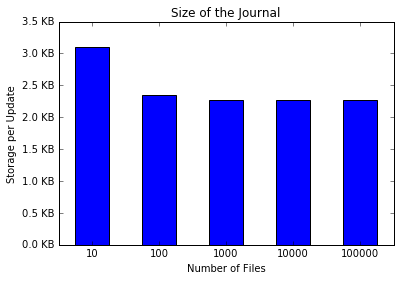

In [4]:
df = pd.DataFrame(columns=['nfiles', 'time', 'size'])

exp = "experiments/fuse/batchfs/results-all/results-run0/*/fsize.txt"
for fname in sorted(glob.glob(exp)):
    with open(fname) as f:
        d = pd.read_csv(f, names=['nfiles', 'time', 'size'])
        d['size'] = d['size']/(1024)
        df = df.append(d, ignore_index=True)

df = df.drop_duplicates('nfiles')
fig, ax = plt.subplots(1, 1)
df['norm'] = df['size']/df['nfiles']
df.plot.bar(x='nfiles', y='norm', ax=ax)
ax.set_title("Size of the Journal")
ax.set_xticklabels([10, 100, 1000, 10000, 100000], rotation=0)
ax.set_xlabel("Number of Files")
ax.set_ylabel("Storage per Update")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f KB'))
ax.legend().remove()
fig.savefig('paper/graphs/behavior-journal-size.png', dpi=400)

print ((2.5)*1024*1000000)/(1024*1024*1024)
print ((2.5)*1024*(10^6))/(1024*1024*1024)

df

job,POSIX,POSIX (no stream),BatchFS,DeltaFS
nfile,,,,
1000,9.617142,4.808571,1.458069,1.090002
10000,44.260844,38.359398,3.009065,2.443523
100000,103.742107,89.502994,6.426479,5.079124


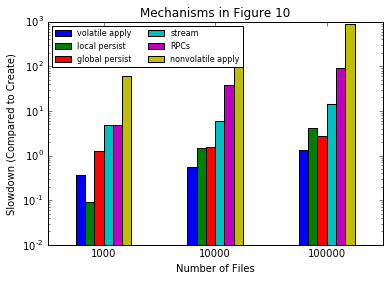

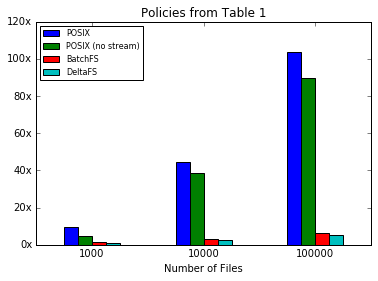

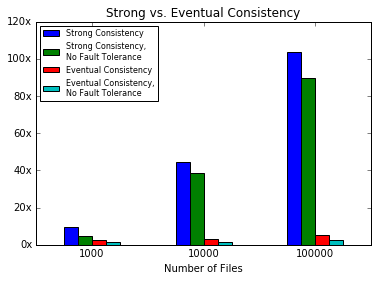

In [5]:
fig, ax = plt.subplots(1, 1)
exp   = "experiments/fuse/batchfs/results-all/"
runs  = ["run0"] #, "run1", "run2", "run3"]
jobs  = ['RPCs', 'create', 'save', 'persist', 'v.apply', 'apply']
files = ['1000', '10000', '100000']

# get nostream
df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])
for nfiles in files:
    for s in ["stream", "nostream"]:
        for run in runs:
            # parse the events execution times
            expdir = exp
            expdir += '/results-' + run 
            expdir += '/' + nfiles 
            with open(expdir + '/summary-' + s + '.txt') as f:
                d = pd.read_csv(f, names=['job', 'time', 'delta'])
                d['rtime'] = d['delta'].apply(to_seconds)
                d['nfile'] = np.full(len(d), nfiles)
                del d['time'], d['delta']
                d['job'] = d['job'] + '-' + s + '-' + run
                df = df.append(d, ignore_index=True)
            # parse the RPCs execution times
            df.loc[len(df)] = ["RPCs-" + s + '-' + run] + [float(nfiles)] + [mdtest(expdir + '/summary-rpcs-' + s + '.txt')]

# massage into graphable format
df = df.pivot(index='nfile', values='rtime', columns='job')
for j in jobs:
    for s in ["stream", "nostream"]:
        job = j + '-' + s
        dfs = [job + '-' + r for r in runs]
        df[j + '-' + s] = df[dfs].mean(axis=1)#

# calculate the phase execution times
df['RPCs'] = df['RPCs-nostream']
df['stream'] = df['RPCs-stream'] - df['RPCs-nostream']
df['create'] = df['create-nostream']
df['local persist'] = df['save-nostream'] - df['create']
df['global persist'] = df['persist-nostream'] - df['create']
df['volatile apply'] = df['v.apply-nostream'] - df['create']
df['nonvolatile apply'] = df['apply-nostream'] - df['create']

# prune
creates = df['create']
slowdowns = df[['volatile apply', 'local persist', 'global persist', 'stream', 'RPCs', 'nonvolatile apply']]
slowdowns = slowdowns[:].div(creates, axis=0)

# graph slowdowns
slowdowns.plot.bar(ax=ax)
ax.set_title("Mechanisms in Figure 10")
ax.set_ylabel("Slowdown (Compared to Create)")
ax.legend(fontsize=8, loc='upper left', ncol=2)
ax.set_xticklabels(files, rotation=0)
ax.set_xlabel("Number of Files")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))
ax.set_yscale('log')
fig.savefig('paper/graphs/slowdown-mechanisms.png', dpi=400)
#############################################################################

fig, ax = plt.subplots(1, 1)

# graph policies
policies = df
policies['create'] = creates
policies['create + volatile apply'] = creates + df['volatile apply']
policies['POSIX (no stream)'] = df['RPCs']
policies['DeltaFS'] = creates + df['local persist']
policies['BatchFS'] = creates + df['local persist'] + df['volatile apply']
policies['RPCs + local persist'] = df['RPCs'] + df['local persist']
policies['create + local persist'] = creates + df['global persist']
policies['create + local persist + volatile apply'] = creates + df['local persist'] + df['volatile apply']
policies['POSIX'] = df['RPCs'] + df['stream']

# normalize and graph
policies = policies[:].div(creates, axis=0)
policies = policies[['POSIX', 'POSIX (no stream)', 'BatchFS', 'DeltaFS']]
policies.plot.bar(ax=ax)
ax.set_ylim(0)
ax.set_title("Policies from Table 1")
ax.legend(fontsize=8, loc='upper left')
ax.set_ylim(0)
ax.set_xticklabels(files, rotation=0)
ax.set_xlabel("Number of Files")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))
fig.savefig('paper/graphs/slowdown-related-work.png', dpi=400)

#############################################################################

fig, ax = plt.subplots(1, 1)

exp   = "experiments/fuse/batchfs/results-all/"
runs  = ["run0"] #, "run1", "run2", "run3"]
jobs  = ['RPCs', 'create', 'save', 'persist', 'v.apply', 'apply']
files = ['1000', '10000', '100000']

# get nostream
df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])
for nfiles in files:
    for s in ["stream", "nostream"]:
        for run in runs:
            # parse the events execution times
            expdir = exp
            expdir += '/results-' + run 
            expdir += '/' + nfiles 
            with open(expdir + '/summary-' + s + '.txt') as f:
                d = pd.read_csv(f, names=['job', 'time', 'delta'])
                d['rtime'] = d['delta'].apply(to_seconds)
                d['nfile'] = np.full(len(d), nfiles)
                del d['time'], d['delta']
                d['job'] = d['job'] + '-' + s + '-' + run
                df = df.append(d, ignore_index=True)
            # parse the RPCs execution times
            df.loc[len(df)] = ["RPCs-" + s + '-' + run] + [float(nfiles)] + [mdtest(expdir + '/summary-rpcs-' + s + '.txt')]

# massage into graphable format
df = df.pivot(index='nfile', values='rtime', columns='job')
for j in jobs:
    for s in ["stream", "nostream"]:
        job = j + '-' + s
        dfs = [job + '-' + r for r in runs]
        df[j + '-' + s] = df[dfs].mean(axis=1)#

# calculate the phase execution times
df['RPCs'] = df['RPCs-nostream']
df['stream'] = df['RPCs-stream'] - df['RPCs-nostream']
df['create'] = df['create-nostream']
df['save'] = df['save-nostream'] - df['create']
df['persist'] = df['persist-nostream'] - df['create']
df['v.apply'] = df['v.apply-nostream'] - df['create']
df['apply'] = df['apply-nostream'] - df['create']

# prune
creates = df['create']
slowdowns = df[['v.apply', 'save', 'persist', 'stream', 'RPCs', 'apply']]
slowdowns = slowdowns[:].div(creates, axis=0)

# graph fair comparisons
fair = df
fair['RPCs+stream'] = df['RPCs'] + df['stream']
fair['create+persist+v.apply'] = creates + df['persist'] + df['v.apply']
fair['create+v.apply'] = creates + df['v.apply']
fair['RPCs'] = df['RPCs']

# normalize and graph
fair = fair[:].div(creates, axis=0)
fair['Strong Consistency'] = fair['RPCs+stream']
fair['Eventual Consistency'] = fair['create+persist+v.apply']
fair['Strong Consistency,\nNo Fault Tolerance'] = fair['RPCs']
fair['Eventual Consistency,\nNo Fault Tolerance'] = fair['create+v.apply']

fair = fair[['Strong Consistency',
              'Strong Consistency,\nNo Fault Tolerance', 
              'Eventual Consistency',
              'Eventual Consistency,\nNo Fault Tolerance', 
             ]]
fair.plot.bar(ax=ax)
ax.set_title("Strong vs. Eventual Consistency")
ax.set_ylim(0)
ax.legend(fontsize=8, loc='upper left')
ax.set_ylim(0, 120)
ax.set_xticklabels(files, rotation=0)
ax.set_xlabel("Number of Files")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))
fig.savefig('paper/graphs/slowdown-strong-v-eventual.png', dpi=400)

policies

# Overhead of RPCs


In [6]:
print slowdowns['RPCs']/slowdowns['v.apply']
print slowdowns['apply']/slowdowns['RPCs']
print slowdowns['save']/slowdowns['persist']
slowdowns

nfile
1000      13.064381
10000     67.827738
100000    66.428664
dtype: float64
nfile
1000      12.807121
10000     10.456132
100000     9.674109
dtype: float64
nfile
1000      0.072021
10000     0.923857
100000    1.478801
dtype: float64


job,v.apply,save,persist,stream,RPCs,apply
nfile,,,,,,
1000,0.368067,0.090002,1.249656,4.808571,4.808571,61.583948
10000,0.565541,1.443523,1.562496,5.901446,38.359398,401.090918
100000,1.347355,4.079124,2.758400,14.239113,89.502994,865.861748


In [7]:
print fair['Strong Consistency']/fair['Eventual Consistency']
print fair['Strong Consistency,\nNo Fault Tolerance']/fair['Eventual Consistency,\nNo Fault Tolerance']

fair


nfile
1000       3.673857
10000     14.149715
100000    20.318663
dtype: float64
nfile
1000       3.514864
10000     24.502320
100000    38.129296
dtype: float64


job,Strong Consistency,"Strong Consistency, No Fault Tolerance",Eventual Consistency,"Eventual Consistency, No Fault Tolerance"
nfile,,,,
1000,9.617142,4.808571,2.617723,1.368067
10000,44.260844,38.359398,3.128038,1.565541
100000,103.742107,89.502994,5.105755,2.347355


# Overhead of Strong Consistency

In [8]:
print fair['Strong Consistency']/fair['Eventual Consistency']
print fair['Strong Consistency']/fair['Strong Consistency,\nNo Fault Tolerance']
print fair['Eventual Consistency']/fair['Eventual Consistency,\nNo Fault Tolerance']


nfile
1000       3.673857
10000     14.149715
100000    20.318663
dtype: float64
nfile
1000      2.000000
10000     1.153846
100000    1.159091
dtype: float64
nfile
1000      1.913446
10000     1.998055
100000    2.175110
dtype: float64
